# Dataset creation

In this notebook I will give a quick recap of the actions required to create the dataset for fine-tuning.
The notebook will be divided into the following sections:
1. Extraction and analysis of annotations
2. Division of official audio into segments
3. Segment analysis: duration frequency, snr, species division
4. Structural division
   - Structural division into json
   - Actual structural division
   - Division analysis (by type and species)
5. Noise class creation
6. Balancing the dataset

In [3]:
import scipy.io
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import os
from pydub import AudioSegment
import numpy as np
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import librosa
import librosa.display
import soundfile as sf

## 1. Extraction and analysis of annotations

In [4]:
bird_tags = scipy.io.loadmat('Bird_tags_Train.mat')["Bird_tags"]    # load annotations
for i, prop in enumerate(bird_tags[12][0][0][0]):
    print(i, prop)

0 ['Fringilla_coelebs']
1 ['20190621_030000.WAV']
2 [[ 6.08474576  1.61016949  1.61016949  6.08474576 42.61703208 45.50069122]]
3 [[42.61703208  6.08474576]
 [42.61703208  1.61016949]
 [45.50069122  1.61016949]
 [45.50069122  6.08474576]
 [42.61703208  6.08474576]]
4 [[2]]


In [5]:
# export species_dict to json, species_dict contains the mapping scientific_name -> common_name
with open('utils/species_dict_map.json') as f:
    species_dict = json.load(f)

In [6]:
orig_audio_path = "E:/Giacomo/Tovanella/Tovanella"
category_info = {}      # detections grouped by category
audio_info = {}         # detections grouped by audio
min_freq = np.infty
max_freq = 0
min_duration = np.infty
above_max_freq = []
for elem in bird_tags:
    tag = elem[0][0][0][0][0]
    scientific_name = tag.replace("_", " ")                 # Fringilla_coelebs -> Fringilla coelebs
    common_name = species_dict.get(scientific_name, "")     # Fringilla coelebs -> Common Chaffinch
    label = "_".join([scientific_name, common_name])        # Fringilla coelebs_Common Chaffinch
    file_name = elem[0][0][0][1][0]
    file_path = os.path.join(orig_audio_path, file_name)
    # calcolo della durata
    start_time, end_time = np.array(elem[0][0][0][2]).flatten()[-2:]
    local_max_freq, local_min_freq = np.array(elem[0][0][0][2]).flatten()[:2]
    duration = end_time - start_time
    if not os.path.exists(file_path) or duration <= 0.2:   # do not store info if file do not exist
        continue
    if local_max_freq > 15:
        above_max_freq.append([file_name, start_time, label])
    max_freq = max(local_max_freq, max_freq)
    min_freq = min(local_min_freq, min_freq)
    min_duration = min(min_duration, duration)
    if label not in category_info:
        category_info[label] = []
    if file_name not in audio_info:
        audio_info[file_name] = []
    category_info[label].append({ "file_name": file_name, "start_time": start_time, "duration": duration, "label": label  })
    audio_info[file_name].append({ "scientific_name": scientific_name, "common_name": common_name, "start_time": start_time, "duration": duration, "label": label })


In [7]:
min_freq*1000, max_freq*1000, min_duration

(11.421319796948382, 18152.54237288135, 0.2054515418502092)

Min duration 0.2054515418502092


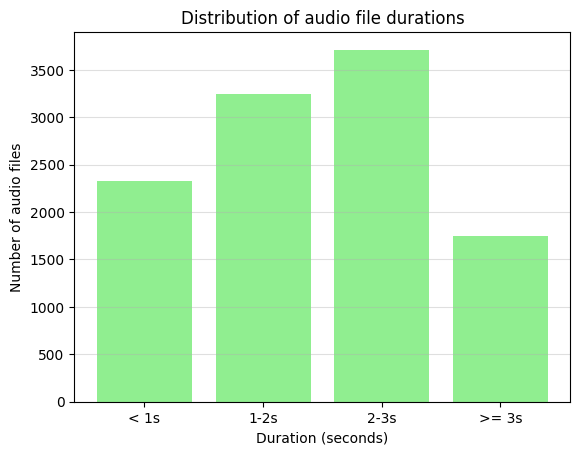

In [8]:
def create_duration_histogram(data):
    """
    Creates a histogram counting the number of audio files based on their duration.

    Args:
        json_file (str): The path to the JSON file.
    """

    durations = []
    for audio_file, annotations in data.items():
        for annotation in annotations:
            durations.append(annotation['duration'])

    print("Min duration", min(durations))

    # Define bins for the histogram
    bins = [0, 1, 2, 3, float('inf')]
    labels = ['< 1s', '1-2s', '2-3s', '>= 3s']

    hist, _ = np.histogram(durations, bins=bins)

    plt.bar(labels, hist, color="lightgreen")
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of audio files')
    plt.title('Distribution of audio file durations')
    plt.grid(axis='y', alpha=0.4)

create_duration_histogram(audio_info)


In [9]:
with open("recap_utils/category_info.json", "w") as f:
    json.dump(category_info, f)

In [10]:
with open("recap_utils/audio_info.json", "w") as f:
    json.dump(audio_info, f)

## 2. Division of official audio into segments


In [11]:
species_list = list(category_info.keys())
species_list[:5]

['Wind_',
 'Regulus ignicapilla_Common Firecrest',
 'Sylvia atricapilla_Eurasian Blackcap',
 'Fringilla coelebs_Common Chaffinch',
 'Troglodytes troglodytes_Eurasian Wren']

In [14]:
true_segments = {}
categories = list(species_list)
count = 0
for j, category in enumerate(categories):
    all_category_audio = category_info[category]
    total_length = len(all_category_audio)
    for i in range(total_length):
        audio_path = all_category_audio[i]["file_name"]
        file_name = audio_path.split('.')[0]        # <filename>.wav
        start_time = all_category_audio[i]["start_time"]
        duration = all_category_audio[i]["duration"]

        start_times = []
        if duration < 1:
            # count += 1
            continue
        if duration < 3:      # add contextual audio
            remaining_time = 3.0 - duration
            start_times.append(max(start_time - remaining_time / 2, 0))
            # count += 1
        elif duration >= 3:
            # count += 1
            start_times.append(max(start_time - 1.5, 0))
            i = 0
            while start_time + i * 1.5 <= start_time + duration:
                # count += 1
                start_times.append(max(start_time + i * 1.5, 0))
                i += 1

        # print(start_time, duration, start_times)

        if audio_path not in true_segments:
            true_segments[audio_path] = {}
        for segm in start_times:
            segm = "{:.1f}".format(segm)
            if segm not in true_segments[audio_path]:
                true_segments[audio_path][segm] = set()
            true_segments[audio_path][segm].add(category)

for audio in true_segments:
    for segm in true_segments[audio]:
        true_segments[audio][segm] = list(true_segments[audio][segm])

In [ ]:
target_path = "E:/Giacomo/Tovanella/all_segments_3/train"
# os.makedirs(target_path, exist_ok=True)
# orig_audio_path = "E:/Giacomo/Tovanella/Tovanella"
# for audio_path, timestamps in true_segments.items():
#     print("Segmenting ", audio_path)
#     audio = AudioSegment.from_file(os.path.join(orig_audio_path, audio_path), format="wav")
#     filename = audio_path.split(".")[0]
#     for start_time, labels in timestamps.items():
#         for label in labels:
#             export_path = os.path.join(
#                 target_path,
#                 label, 
#                 f"{filename}_{start_time.replace('.', '_')}.wav"
#             )
#             if os.path.exists(export_path):
#                 continue
#             start_time_float = float(start_time)
#             segment = audio[start_time_float*1000:start_time_float*1000 + 3000]
#             os.makedirs(os.path.join(target_path, label), exist_ok=True)
#             segment.export(export_path, format="wav")

In [15]:
with open("recap_utils/true_segments.json", "w") as f:
    json.dump(true_segments, f)

## 3. Segment analysis: duration frequency, snr, species division


## 4. Structural division


In [54]:
species_count = {}
for specie in os.listdir(target_path):
    species_count[specie] = len(os.listdir(os.path.join(target_path, specie)))

In [55]:
# get date count by species
target = 'E:/Giacomo/Tovanella/all_segments_3/train'
species_date_count = {}
for specie in os.listdir(target):
    if target not in species_date_count:
        species_date_count[specie] = {}
    audio_names = os.listdir(os.path.join(target, specie))
    date_counts = { audio.split("_")[0]: 0 for audio in audio_names }
    for date in date_counts:
        species_date_count[specie][date] = { "count": sum(date in audio for audio in audio_names), "is_training": False}

In [56]:
for specie in species_date_count.keys():
    dates = list(species_date_count[specie].keys())
    date_count = len(dates)
    values = [ value["count"] for value in species_date_count[specie].values() ]
    if date_count <= 1:
        # species_date_count[specie][dates[0]]["to_remove"] = True
        continue
    elif date_count == 2:
        greatest_date = dates[np.argmax(values)]
        species_date_count[specie][greatest_date]["is_training"] = True
    else:
        greatest_value_index = np.argmax(values)
        greatest_value_date = dates[greatest_value_index]
        greatest_value = species_date_count[specie][greatest_value_date]["count"]
        species_date_count[specie][greatest_value_date]["is_training"] = True
        
        other_values = [ value["count"] if value["is_training"] == False else 0 for value in species_date_count[specie].values() ]
        sum_other_values = sum(other_values)
        while sum_other_values > greatest_value / 2:
            greatest_value_index = np.argmax(other_values)
            greatest_value_date = dates[greatest_value_index]
            species_date_count[specie][greatest_value_date]["is_training"] = True
            sum_other_values -= species_date_count[specie][greatest_value_date]["count"]

### visualize division in training e test set

In [ ]:
# with open('recap_utils/species_date_count.json', 'w') as f:
#     json.dump(species_date_count, f)

In [59]:
with open('recap_utils/species_date_count.json') as f:
    species_date_count = json.load(f)

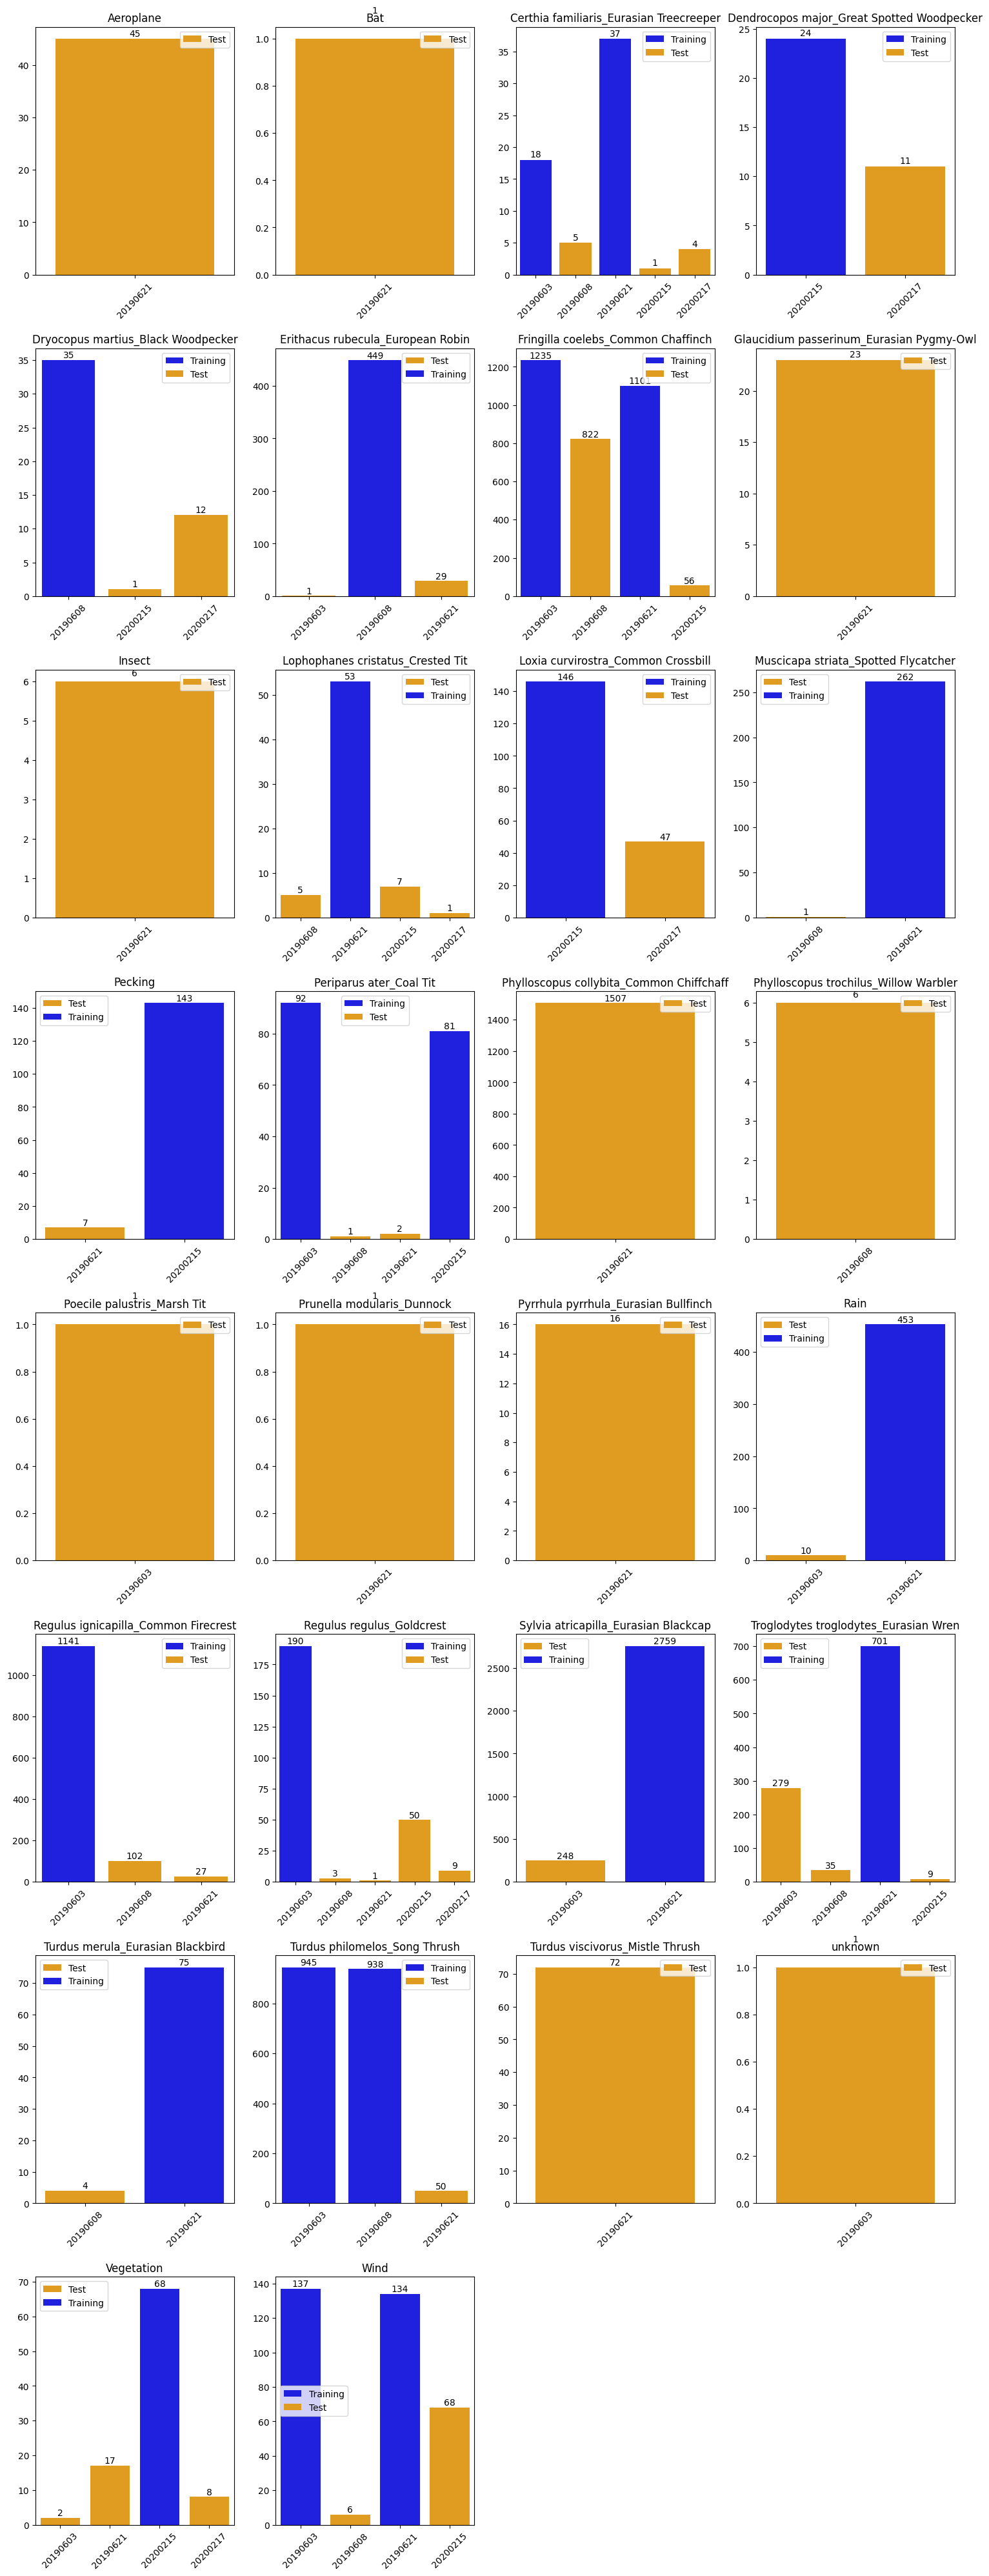

In [60]:
n_species = len(species_date_count.keys())

cols = 4
rows = (n_species // cols) + (n_species % cols != 0) 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()
color_palette = {"Training": "blue", "Test": "orange"}  # Puoi cambiare i colori qui

for i, species in enumerate(species_date_count.keys()):
    dates = list(species_date_count[species].keys())
    counts = [value["count"] for value in species_date_count[species].values()]
    is_training = ["Training" if value["is_training"] else "Test" for value in species_date_count[species].values()]

    sns.barplot(x=dates, y=counts, ax=axes[i], hue=is_training, palette=color_palette)  # Usa la palette qui

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.1, str(count), ha='center', va='bottom')
    axes[i].set_title(species)
    axes[i].tick_params(axis='x', rotation=45)
    
for i in range(n_species, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Aggiusta lo spazio tra i grafici
plt.show()


In [61]:
species_date_count["Certhia familiaris_Eurasian Treecreeper"]

{'20190603': {'count': 18, 'is_training': True},
 '20190608': {'count': 5, 'is_training': False},
 '20190621': {'count': 37, 'is_training': True},
 '20200215': {'count': 1, 'is_training': False},
 '20200217': {'count': 4, 'is_training': False}}

In [62]:
division = {}
train_folder = "E:/Giacomo/Tovanella/all_segments_3/train"
test_folder = "E:/Giacomo/Tovanella/all_segments_3/test"
removed = "E:/Giacomo/Tovanella/all_segments_3/removed"
os.makedirs(test_folder, exist_ok=True)
os.makedirs(removed, exist_ok=True)
for specie in os.listdir(train_folder):
    if len(species_date_count[specie]) <= 1:
        os.rename(
            os.path.join(train_folder, specie),
            os.path.join(removed, specie)
        )
        continue
    os.makedirs(os.path.join(test_folder, specie), exist_ok=True)
    for audio in os.listdir(os.path.join(train_folder, specie)):
        test_dates = [date for date in species_date_count[specie].keys() 
                      if species_date_count[specie][date]["is_training"] == False]
        audio_date = audio.split("_")[0]
        if audio_date in test_dates:
            os.rename(
                os.path.join(train_folder, specie, audio),
                os.path.join(test_folder, specie, audio)
            )

In [63]:
# valid_folder = "E:/Giacomo/Tovanella/DATASET/validation"
species_folders = os.listdir(train_folder)
species_count = { folder: {
    "train_count": len(os.listdir(os.path.join(train_folder, folder))),
    # "valid_count": len(os.listdir(os.path.join(valid_folder, folder))),
    "test_count": len(os.listdir(os.path.join(test_folder, folder))),
    } for folder in species_folders if folder != "Noise" }
df = pd.DataFrame(species_count).T
df.sort_values(by=["train_count", "test_count"], ascending=False)

,train_count,test_count
Sylvia atricapilla_Eurasian Blackcap,2759,248
Fringilla coelebs_Common Chaffinch,2336,878
Turdus philomelos_Song Thrush,1883,50
Regulus ignicapilla_Common Firecrest,1141,129
Troglodytes troglodytes_Eurasian Wren,701,323
Rain,453,10
Erithacus rubecula_European Robin,449,30
Wind,271,74
Muscicapa striata_Spotted Flycatcher,262,1
Regulus regulus_Goldcrest,190,63


## 5. Noise class creation

In [56]:
noise_folder = "E:/Giacomo/Tovanella/all_segments_2/train/Noise"
os.makedirs(noise_folder, exist_ok=True)

In [ ]:
# manually checked
safe_audio_for_noise = [
    '20190621_010000.WAV',
    '20190621_020000.WAV',
    '20190621_210000.WAV',
    '20200215_070000.WAV',
    '20200215_110000.WAV',
    '20200217_000000.WAV',
    '20200217_140000.WAV',
    '20200217_160000.WAV',
    '20190603_230000.WAV'
]
    

In [63]:
for audio_path in safe_audio_for_noise:
    audio = AudioSegment.from_file(os.path.join(orig_audio_path, audio_path), format="wav")
    for i in range(7):
        export_path = os.path.join(
            noise_folder,
            f"{audio_path.split('.')[0]}_{i}.wav"
        )
        if os.path.exists(export_path):
            continue
        segment = audio[i*3000:i*3000 + 3000]
        segment.export(export_path, format="wav")

## 6. Balancing

Some classes has more than 1000 samples, whereas most of the other classes cannot even reach 100 samples count.
To balance the dataset, I decided to remove samples from the majority, based on the SNR value.
To calculate the SNR, we need a sample of noise sound, in this case I have an entire folder of 3s segments of background noise.

### 6.1 SNR filter

In [ ]:
def calculate_snr(audio_path):
    """
    Calculates the Signal-to-Noise Ratio (SNR) of an audio file with respect to a noise segment.

    - audio_path: path to the audio file
    - noise_start, noise_end: time interval in seconds where the noise is isolated
    """
    
    noise_audio = "E:/Giacomo/Tovanella/all_segments_2/train/Noise/20190603_230000_0.wav"
    y_noise, sr_noise = librosa.load(noise_audio, sr=None)
    
    noise_sample = y_noise[int(0 * sr_noise) : int(3 * sr_noise)]
    
    y, sr = librosa.load(audio_path, sr=None)
    signal_power = np.mean(y**2)
    noise_power = np.mean(noise_sample**2)
    
    if noise_power == 0:
        return np.inf  # Segnale pulitissimo
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

SNR: 4.74 dB


<Axes: ylabel='Count'>

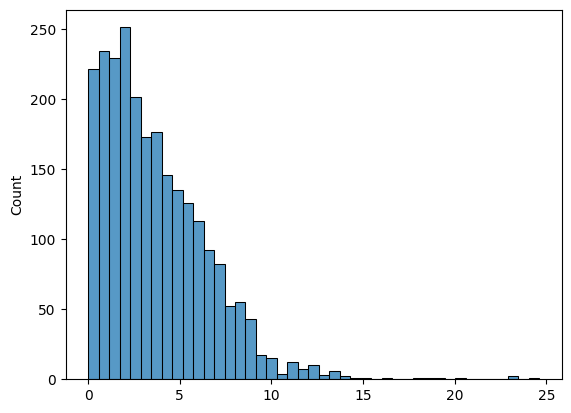

In [152]:
specie = "E:/Giacomo/Tovanella/all_segments_2/train/Sylvia atricapilla_Eurasian Blackcap"
snrs = []
saved_audio = {}
best_snr = {}
for audio in os.listdir(specie):
    snr = calculate_snr(os.path.join(specie, audio))
    if snr <= 0:
        saved_audio[audio] = snr
    if snr > 10:
        best_snr[audio] = snr
    snrs.append(snr)

sns.histplot(snrs)

The difference in quality is clear. From now on, I'm gonna choose for the best samples

In [99]:
# Fringilla coelebs_Common Chaffinch
# saved_audio["20190608_140000_146_2.wav"], best_snr["20190603_030000_237_0.wav"]

In [95]:
len(saved_audio), len(os.listdir(specie))

(709, 2164)

In [113]:
species_to_reduce = [
    "Fringilla coelebs_Common Chaffinch",
    "Sylvia atricapilla_Eurasian Blackcap",
    "Turdus philomelos_Song Thrush",
    "Regulus ignicapilla_Common Firecrest",
    "Troglodytes troglodytes_Eurasian Wren",
    "Erithacus rubecula_European Robin"
]

In [117]:
with open("recap_utils/snr_info.json") as f:
    info = json.load(f)

In [148]:
train_folder = "E:/Giacomo/Tovanella/all_segments_2/train"
info = {}
for specie in species_to_reduce:
    info[specie] = {}
    for audio_path in os.listdir(os.path.join(train_folder, specie)):
        full_audio_path = os.path.join(train_folder, specie, audio_path)
        snr = calculate_snr(full_audio_path)
        info[specie][audio_path] = snr

In [ ]:
# with open("recap_utils/snr_info.json", "w") as f:
#     json.dump(info, f)

In [128]:
info["Fringilla coelebs_Common Chaffinch"]["20190603_070000_130_0.wav"]

-1.1358701437711716

In [ ]:
threshold = 0
removed_folder = "E:/Giacomo/Tovanella/all_segments_2/train_removed"
for specie_name in info:
    for audio_path in info[specie_name]:
        snr = info[specie_name][audio_path]
        if snr <= threshold:
            os.makedirs(os.path.join(removed_folder, specie_name), exist_ok=True)
            if not os.path.exists(os.path.join(train_folder, specie_name, audio_path)):
                continue
            os.rename(
                os.path.join(train_folder, specie_name, audio_path),
                os.path.join(removed_folder, specie_name, audio_path)
            )

### 6.2 Band pass filter

In [109]:
import librosa
import scipy.signal as signal
import numpy as np
import soundfile as sf

def bandpass_filter(audio, sr, lowcut=500, highcut=15000, order=6):
    """
    Applica un filtro passa-banda a un segnale audio.
    
    - audio: array dell'audio
    - sr: sample rate
    - lowcut: frequenza di taglio inferiore (Hz)
    - highcut: frequenza di taglio superiore (Hz)
    - order: ordine del filtro (maggiore = transizione più netta)
    """
    nyquist = sr / 2  # Frequenza di Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, audio)

# Carica un file audio
test = "E:/Giacomo/Tovanella/all_segments_2/train/Fringilla coelebs_Common Chaffinch/20190608_140000_146_2.wav"
y, sr = librosa.load(test, sr=None)

# Applica il filtro passa-banda (1kHz - 15 kHz)
y_filtered = bandpass_filter(y, sr)

# Salva l'audio filtrato
sf.write("audio_filtered.wav", y_filtered, sr)


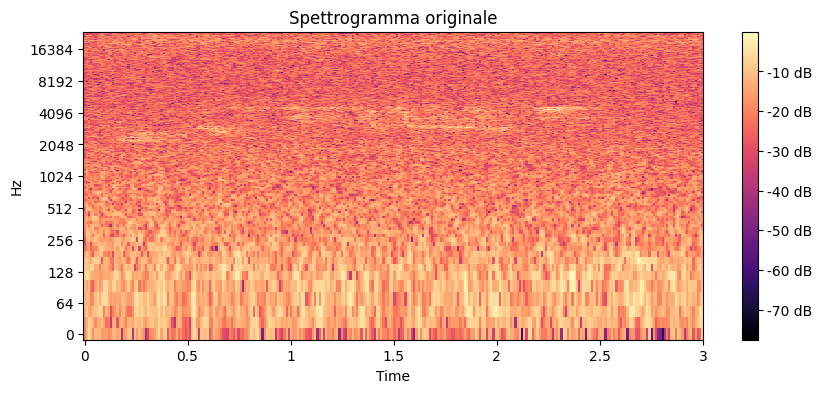

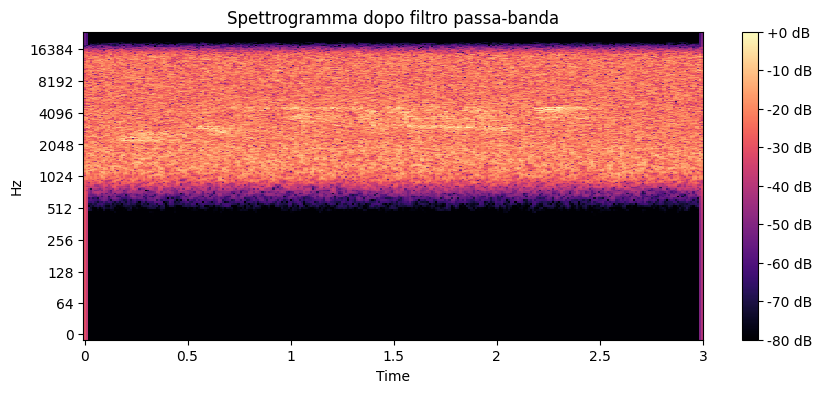

In [ ]:


def bandpass_filter(audio, sr, lowcut=500, highcut=15000, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, audio)

# Carica il file audio
audio_path = test
audio, sr = librosa.load(audio_path, sr=None)

# Spettrogramma prima del filtro
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spettrogramma originale")
plt.show()

# Applica il filtro passa-banda
filtered_audio = bandpass_filter(audio, sr)

# Spettrogramma dopo il filtro
plt.figure(figsize=(10, 4))
D_filtered = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_audio)), ref=np.max)
librosa.display.specshow(D_filtered, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spettrogramma dopo filtro passa-banda")
plt.show()

# Salva l'audio filtrato
sf.write("filtered_audio.wav", filtered_audio, sr)


### WABAD Integration

In [5]:
wabad_folder = "E:/Giacomo/Tovanella/wabad_segments"
species_to_integrate = [
    "Regulus regulus_Goldcrest",
    "Loxia curvirostra_Common Crossbill",
    "Certhia familiaris_Eurasian Treecreeper",
    "Lophophanes cristatus_Crested Tit",
    "Erithacus rubecula_European Robin",
    "Dendrocopos major_Great Spotted Woodpecker",
    "Dryocopus martius_Black Woodpecker"
]

In [7]:
train_folder = 'E:/Giacomo/Tovanella/all_segments_2/train'
for specie in species_to_integrate:
    wabad_specie = os.path.join(wabad_folder, specie)
    for audio in os.listdir(wabad_specie):
        os.rename(
            os.path.join(wabad_specie, audio),
            os.path.join(train_folder, specie, audio)
        )

In [41]:
removed_folder = "E:/Giacomo/Tovanella/all_segments_2/train_removed"

for path in less_one_second:
    specie, audio = path.split('/')
    os.makedirs(os.path.join(train_folder, specie), exist_ok=True)
    os.rename(
        os.path.join(train_folder, specie, audio),
        os.path.join(removed_folder, specie, audio)
    )

FileNotFoundError: [WinError 2] Impossibile trovare il file specificato: 'E:/Giacomo/Tovanella/all_segments_2/train\\Wind\\20190621_090000_12_7.wav' -> 'E:/Giacomo/Tovanella/all_segments_2/train_removed\\Wind\\20190621_090000_12_7.wav'